In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss,ccf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

In [9]:
data = pd.read_csv("~/Downloads/brisbane_water_quality.csv",encoding="latin1")
data.head()

,Timestamp,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Chlorophyll [quality],Temperature,Temperature [quality],Dissolved Oxygen,Dissolved Oxygen [quality],Dissolved Oxygen (%Saturation),Dissolved Oxygen (%Saturation) [quality],pH,pH [quality],Salinity,Salinity [quality],Specific Conductance,Specific Conductance [quality],Turbidity,Turbidity [quality]
0,2023-08-04 23:00:00,1468,4.834,73.484,1.621,NaN,20.018,NaN,7.472,NaN,101.175,NaN,8.176,NaN,35.215,NaN,53.262,NaN,2.068,NaN
1,2023-08-04 23:30:00,1469,2.544,106.424,1.959,NaN,19.986,NaN,7.455,NaN,100.884,NaN,8.175,NaN,35.209,NaN,53.254,NaN,1.994,NaN
2,2023-08-04 23:00:00,1470,1.260,156.755,1.620,NaN,20.001,NaN,7.430,NaN,100.571,NaN,8.171,NaN,35.207,NaN,53.252,NaN,2.030,NaN
3,2023-08-04 23:30:00,1471,0.760,281.754,1.761,NaN,19.983,NaN,7.419,NaN,100.398,NaN,8.171,NaN,35.211,NaN,53.257,NaN,1.973,NaN
4,2023-08-04 23:00:00,1472,3.397,244.637,1.635,NaN,19.986,NaN,7.429,NaN,100.538,NaN,8.171,NaN,35.208,NaN,53.253,NaN,1.944,NaN


In [10]:
data2 = data.drop(columns = ["Chlorophyll [quality]","Temperature [quality]",
                     "Dissolved Oxygen [quality]","Dissolved Oxygen (%Saturation) [quality]",
                     "pH [quality]","Salinity [quality]","Specific Conductance [quality]",
                     "Turbidity [quality]","Record number"])

data2['Timestamp'] = pd.to_datetime(data2['Timestamp'])

df = data2[data2['Timestamp'] <= '2023-12-01']
df.tail()

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity
5773,2023-11-30 22:00:00,14.401,193.900,2.650,27.192,6.975,107.282,8.016,35.731,54.126,1.071
5774,2023-11-30 22:30:00,25.832,260.382,1.959,27.204,7.010,107.840,8.017,35.729,54.123,0.993
5775,2023-11-30 23:00:00,31.462,212.173,1.994,27.151,6.927,106.467,8.018,35.718,54.106,1.114
5776,2023-11-30 23:30:00,14.771,280.591,2.430,27.123,6.930,106.465,8.015,35.719,54.106,0.784
5777,2023-12-01 00:00:00,19.432,279.987,0.164,27.100,NaN,NaN,7.929,35.720,54.107,0.393


In [11]:
compte =0
for i in df["pH"].isna():
    if i == True:
        compte+=1
print(compte)

27


In [12]:
df.dropna(subset=["pH","Temperature","Dissolved Oxygen"], inplace=True)
print(df["pH"].isna().sum())

0


In [14]:
df["Timestamp"]=pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
df["Hour"] = df["Timestamp"].dt.hour
df['Year'] = df["Timestamp"].dt.year
df['Month'] = df["Timestamp"].dt.month
df['Day'] = df["Timestamp"].dt.dayofweek

In [27]:
import torch
print(torch.__version__)

2.3.1+cpu


In [28]:
from autogluon.tabular import TabularPredictor
from autogluon.timeseries import TimeSeriesPredictor
# 1) Convertir en datetime
df = df.rename(columns={"Timestamp": "timestamp"})
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 2) Trier par date
df = df.sort_values("timestamp")

# 3) Supprimer les doublons de timestamp
df = df.drop_duplicates(subset=["timestamp"], keep="last")

# 4) Recréer une grille régulière (timestamp devient index)
df = df.set_index("timestamp").asfreq("30min")

# 5) Remplir les trous
df["pH"] = df["pH"].interpolate()

# 6) Remettre timestamp comme colonne
df = df.reset_index()

# 7) Ajouter item_id
df["item_id"] = "serie_ph"

# 8) Réorganiser les colonnes
df = df[["item_id", "timestamp", "pH","Temperature", "Dissolved Oxygen","Average Water Speed"]]

df.head()

,item_id,timestamp,pH,Temperature,Dissolved Oxygen,Average Water Speed
0,serie_ph,2023-08-04 23:00:00,8.158,19.834,7.430,1.596
1,serie_ph,2023-08-04 23:30:00,8.158,19.829,7.435,6.622
2,serie_ph,2023-08-05 00:00:00,8.159,19.822,7.459,9.138
3,serie_ph,2023-08-05 00:30:00,8.166,19.804,7.446,2.982
4,serie_ph,2023-08-05 01:00:00,8.168,19.770,7.454,9.851


In [125]:
predictor = TimeSeriesPredictor(
    prediction_length=30,
    target="pH",
    freq="30min"
)
predictor.fit(df)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels\ag-20251224_212458'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       1.81 GB / 7.41 GB (24.4%)
Disk Space Avail:   287.11 GB / 475.45 GB (60.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': '30min',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'pH',
 'verbosity': 2}

Provided train_data has 5666 rows, 1 time series. Median time series length is 5666 (min=5666, max=5666). 

Provided data contains following columns:
	target: 'pH'

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


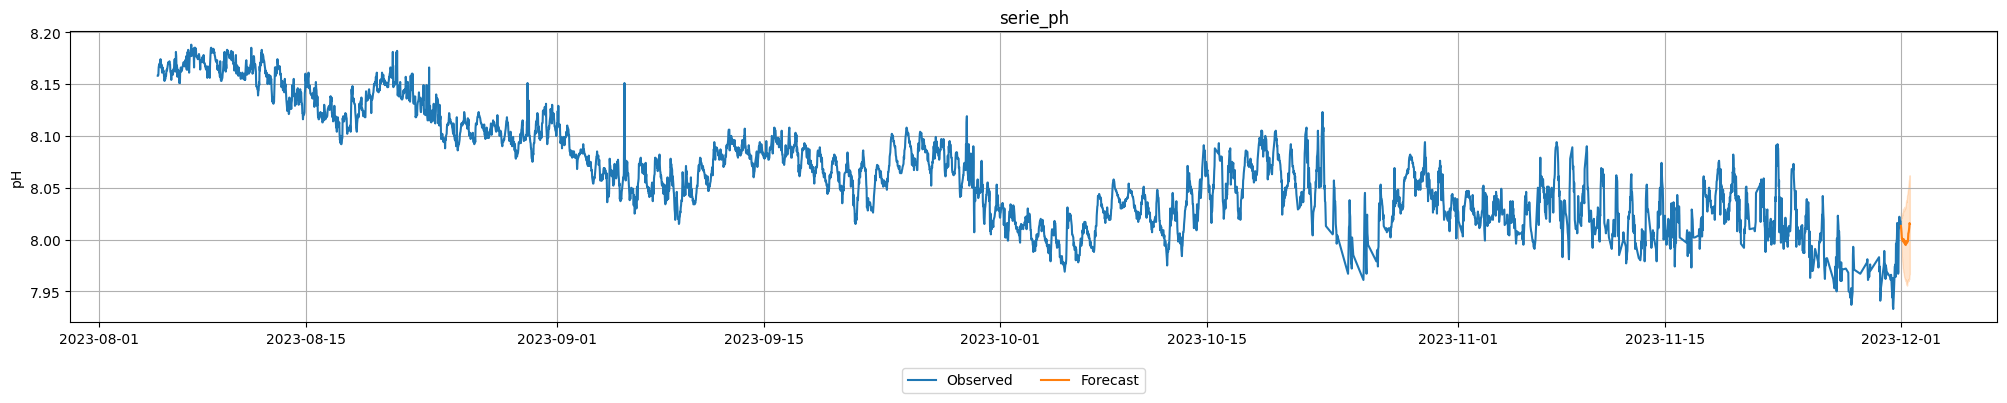

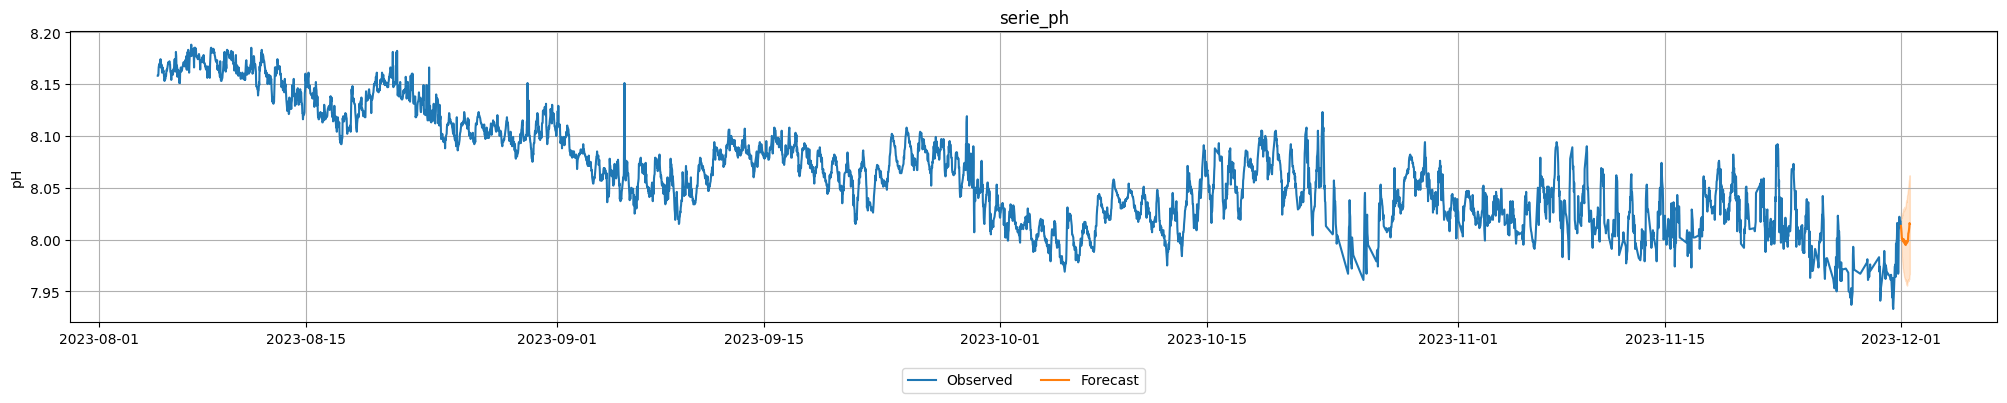

In [126]:
forecast = predictor.predict(df)
predictor.plot(df, forecast)

In [128]:
predictor.leaderboard()
predictor.get_model_best()

'WeightedEnsemble'

In [29]:
from sklearn.model_selection import train_test_split
import os
import random

extraction = "Downloads/DatasetsTimeSeries"
os.makedirs(extraction, exist_ok=True)

cible = "pH"
X = df.drop(columns = [cible])
y = df[cible]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
train_df = pd.concat([X_train,y_train],axis=1)
test_df = pd.concat([X_test,y_test],axis=1)

train_chemin = os.path.join(extraction,"train.csv")
test_chemin = os.path.join(extraction,"test.csv")

train_df.to_csv(train_chemin,index= False)
test_df.to_csv(test_chemin,index= False)

In [30]:
def change_etat(etat):
    np.random.seed(etat)
    random.seed(etat)
    
def preprocess(df, label=True):
    nouveau_df = df.copy()
    if label:
        nouveau_df["pH"] =  np.log(nouveau_df["pH"] +1)
    return nouveau_df

In [31]:
def train_pipeline(chemin, etat, exp_chemin):
    change_etat(etat)
    train_df = pd.read_csv(os.path.join(chemin,"train.csv"))
    test_df = pd.read_csv(os.path.join(chemin,"test.csv"))  
    
    pre_train = preprocess(train_df, label=True)
    pre_test = preprocess(test_df, label=False)
    
    cible = "pH"
    metrique = "r2"
    
    predicteur = TabularPredictor(label=cible,eval_metric = metrique,path = exp_chemin)
    predicteur.fit(train_data=train_df)
    predictions = np.exp(predicteur.predict(test_df))
    return predicteur

In [32]:
args = {"chemin":extraction,"etat":123,"exp_chemin":"./autogluon_experiment"}
predicteur = train_pipeline(**args)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       1.25 GB / 7.41 GB (16.8%)
Disk Space Avail:   285.14 GB / 475.45 GB (60.0%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "./autogl

[1000]	valid_set's l2: 9.90789e-05	valid_set's r2: 0.968259


	0.9684	 = Validation score   (r2)
	3.58s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 8.90342e-05	valid_set's r2: 0.971477


	0.9716	 = Validation score   (r2)
	2.44s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	0.9695	 = Validation score   (r2)
	3.53s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	0.9721	 = Validation score   (r2)
	83.33s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	0.9737	 = Validation score   (r2)
	1.24s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.9632	 = Validation score   (r2)
	11.02s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	0.9739	 = Validation score   (r2)
	1.8s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	0.9676	 = Validation score   (r2)
	67.94s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMLarge ...


[1000]	valid_set's l2: 9.01425e-05	valid_set's r2: 0.971122


	0.9712	 = Validation score   (r2)
	2.96s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'KNeighborsDist': 0.652, 'XGBoost': 0.261, 'ExtraTreesMSE': 0.043, 'NeuralNetFastAI': 0.043}
	0.9843	 = Validation score   (r2)
	0.11s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 179.75s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 3076.0 rows/s (500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./autogluon_experiment")


In [52]:
df = df.sort_values("timestamp")
df_train = df.iloc[:-90].copy() 
df_test = df.iloc[-90:].copy()
print(df_train.shape, df_test.shape)

(5576, 6) (90, 6)


In [53]:
predictor = TabularPredictor( label="pH", 
                             path="./autogluon_experiment" ).fit(df_train)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       1.36 GB / 7.41 GB (18.3%)
Disk Space Avail:   281.91 GB / 475.45 GB (59.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "./autogl

[1000]	valid_set's rmse: 0.00831822
[2000]	valid_set's rmse: 0.00793512
[3000]	valid_set's rmse: 0.00777315
[4000]	valid_set's rmse: 0.00766942
[5000]	valid_set's rmse: 0.00759452
[6000]	valid_set's rmse: 0.00755121
[7000]	valid_set's rmse: 0.00749962
[8000]	valid_set's rmse: 0.00748367
[9000]	valid_set's rmse: 0.0074689
[10000]	valid_set's rmse: 0.00744013


	-0.0074	 = Validation score   (-root_mean_squared_error)
	5.01s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.00727501
[2000]	valid_set's rmse: 0.00711637
[3000]	valid_set's rmse: 0.00710649
[4000]	valid_set's rmse: 0.0071027


	-0.0071	 = Validation score   (-root_mean_squared_error)
	2.27s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.0067	 = Validation score   (-root_mean_squared_error)
	1.97s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-0.007	 = Validation score   (-root_mean_squared_error)
	61.78s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.0062	 = Validation score   (-root_mean_squared_error)
	0.7s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.0102	 = Validation score   (-root_mean_squared_error)
	4.87s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0073	 = Validation score   (-root_mean_squared_error)
	0.51s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.0095	 = Validation score   (-root_mean_squared_error)
	45.92s	 = Training   runtime
	0.01s	 = Validation runti

[1000]	valid_set's rmse: 0.00680108


	-0.0068	 = Validation score   (-root_mean_squared_error)
	1.97s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'KNeighborsDist': 0.4, 'ExtraTreesMSE': 0.32, 'LightGBM': 0.08, 'RandomForestMSE': 0.08, 'CatBoost': 0.08, 'XGBoost': 0.04}
	-0.0059	 = Validation score   (-root_mean_squared_error)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 126.64s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 3596.2 rows/s (558 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./autogluon_experiment")


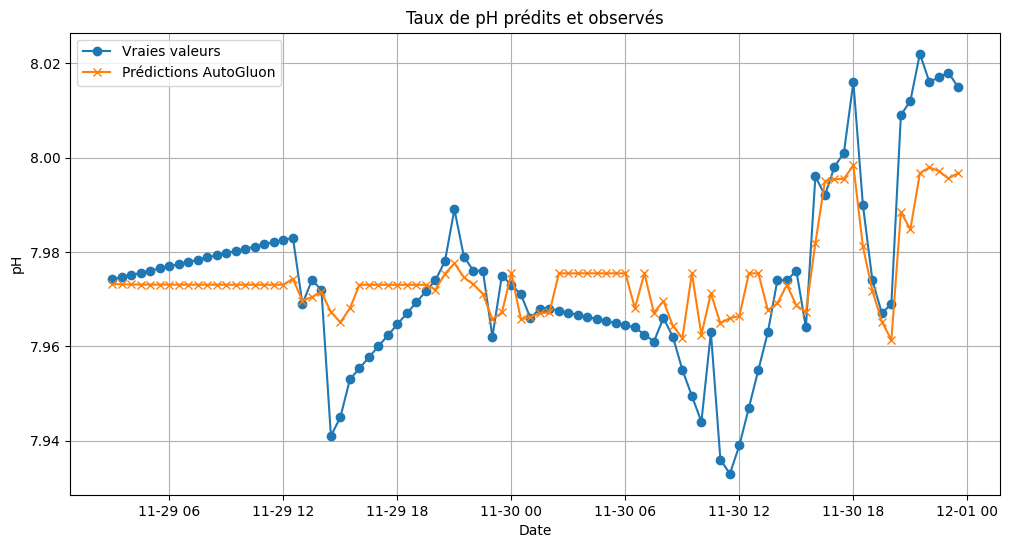

In [54]:
preds = predictor.predict(df_test)
df_test["prediction"] = preds
df_test = df_test.set_index("timestamp")

plt.figure(figsize=(12,6))
plt.plot(df_test.index,df_test["pH"].values, label="Vraies valeurs", marker="o")
plt.plot(df_test.index,df_test["prediction"].values, label="Prédictions AutoGluon", marker="x")

plt.title("Taux de pH prédits et observés")
plt.xlabel("Date")
plt.ylabel("pH")
plt.legend()
plt.grid(True)
plt.show()